In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import csv
import os

In [28]:
path_truth = "/home/serodio/Downloads/archive/labels.csv"

truth = {}
with open(path_truth) as f:
    reader = csv.reader(f)
    for row in reader:
        if row[0] == "id":
            continue
        truth[f"seq_{format(int(row[0]), '06')}.jpg"] = int(row[1])

In [29]:
csv_save_cloud = "cloud/local_cloud_1fac85f4-8538-4205-860f-8745f7687861"
csv_predict_cloud = "cloud/cloud_e1f4fdb7-e302-438c-99f1-497a1a10c168"
csv_save_edge = "edge/local-edge_06b95dfb-134d-4d12-a527-6bcb4b7219cb"
csv_predict_edge = "edge/edge_77e9939d-a0ee-42b5-ab0b-e7b2e71b3954"

In [30]:
def get_metrics(results, req_metrics):
    time_req = []
    time_server = []
    pred = []
    truth_list = []
    for result in results:
        tag = result["tag"]
        time_req.append(req_metrics[tag]["request_time"])
        time_server.append(result["time_server"])
        pred.append(result["response"].get("person", 0))
        truth_list.append(truth[tag])
    time_req = np.array(time_req)
    time_server = np.array(time_server)
    pred = np.array(pred)
    truth_list = np.array(truth_list)
    diff = pred-truth_list
    correct = diff.size - np.count_nonzero(diff)
    max_diff = max(np.max(diff), np.max(-diff))
    return (
        np.sqrt(np.mean((diff)**2)),
        np.mean(np.abs(diff)),
        correct,
        max_diff,
        np.mean(time_req - time_server),
        np.std(time_req - time_server),
        np.mean(time_server),
        np.std(time_server),
        np.mean(time_req),
        np.std(time_req)
    )

def get_all_metrics(metrics_path, metrics_file):
    metrics = {}
    with open(os.path.join(metrics_path, metrics_file), "r") as f:
        run_dict = json.load(f)
    for run, run_info in run_dict.items():
        with open(os.path.join(metrics_path, f"{run_info['id']}.json"), "r") as f:
            exp_results = json.load(f)
        
        metrics[run] = get_metrics(exp_results, run_info["requests"])
    return metrics
        
def csv_metrics_save(csv_path, metrics_path):
    csv_content = {}
    with open(f"{csv_path}.csv", "r") as f:
        reader = csv.reader(f)
        for row in reader:
            if row[0] == "start":
                continue
            csv_content[int(row[0])] = [int(row[2])-int(row[1]), int(row[3])-int(row[2]),int(row[4])-int(row[0])]
            
    with open(os.path.join(metrics_path, f"{csv_path.split('_')[-1]}.json"), "r") as f:
        exp_results = json.load(f)
    pred = []
    time_req = []
    total = []
    time_server = []
    for result in exp_results:
        tag = int(result["time_device"])
        if tag not in csv_content:
            continue
        pred.append(csv_content[tag][0]/1000)
        time_req.append(csv_content[tag][1]/1000)
        total.append(csv_content[tag][2]/1000)
        time_server.append(result["time_server"])
    time_req = np.array(time_req)
    time_server = np.array(time_server)
    pred = np.array(pred)
    total = np.array(total)
    return (
            np.mean(time_req - time_server),
            np.std(time_req - time_server),
            np.mean(pred),
            np.std(pred),
            np.mean(total),
            np.std(total)
        )
        
def csv_metrics_predict(csv_path, metrics_path):
    csv_content = {}
    with open(f"{csv_path}.csv", "r") as f:
        reader = csv.reader(f)
        for row in reader:
            if row[0] == "start":
                continue
            csv_content[int(row[0])] = [int(row[2])-int(row[1]), int(row[3])-int(row[0])]
            
    with open(os.path.join(metrics_path, f"{csv_path.split('_')[-1]}.json"), "r") as f:
        exp_results = json.load(f)
    time_req = []
    total = []
    time_server = []
    for result in exp_results:
        tag = int(result["time_device"])
        if tag not in csv_content:
            continue
        time_req.append(csv_content[tag][0]/1000)
        total.append(csv_content[tag][1]/1000)
        time_server.append(result["time_server"])
    time_req = np.array(time_req)
    time_server = np.array(time_server)
    total = np.array(total)
    return (
            np.mean(time_req - time_server),
            np.std(time_req - time_server),
            np.median(total),
            np.std(total)
        )
        

In [31]:
plt.rcParams["figure.figsize"] = (10,6) # config figure size

In [55]:
# Execução com 2000 amostras
edge = get_all_metrics("edge", "edge_metrics.json")
cloud = get_all_metrics("cloud", "cloud_metrics.json")

labels = ['yolov5n', 'yolov5s', 'yolov5m', 'yolov5l', 'yolov5x']
rmse_edge = []
rmse_cloud = []
time_com_edge = []
err_com_edge = []
time_com_cloud = []
err_com_cloud = []
time_proc_edge = []
time_proc_cloud = []

for label in labels:
    rmse_edge.append(edge[label][0] if label in edge else 0)
    rmse_cloud.append(cloud[label][0] if label in cloud else 0)
    time_com_edge.append(edge[label][4] if label in edge else 0)
    time_com_cloud.append(cloud[label][4] if label in cloud else 0)
    time_proc_edge.append(edge[label][6] if label in edge else 0)
    time_proc_cloud.append(cloud[label][6] if label in cloud else 0)



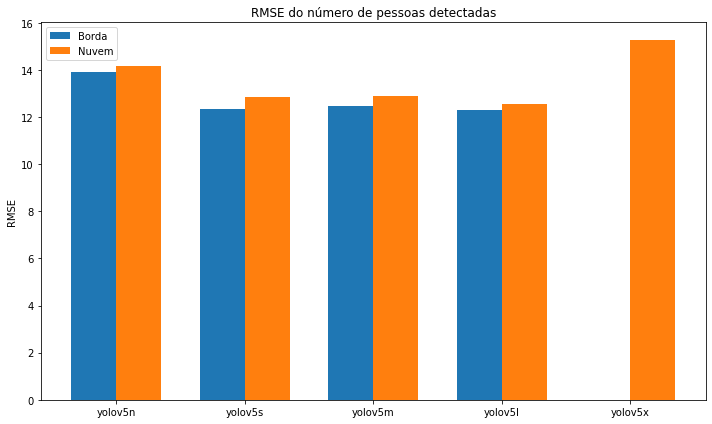

In [57]:
x = np.arange(len(labels))
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, rmse_edge, width, label='Borda')
rects2 = ax.bar(x + width/2, rmse_cloud, width, label='Nuvem')

ax.set_ylabel('RMSE')
ax.set_title('RMSE do número de pessoas detectadas')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()

plt.show()

In [65]:
rmse_edge

[13.895197011917464,
 12.336308199781651,
 12.466795899508421,
 12.313549447661304,
 0]

In [66]:
rmse_cloud

[14.15528169977553,
 12.842896869476139,
 12.88838624498816,
 12.544700076127766,
 15.255654689327496]

In [80]:
# Execução com 100 amostras
edge = get_all_metrics("edge_1", "edge_metrics.json")
cloud = get_all_metrics("cloud_1", "cloud_metrics.json")

labels = ['yolov5n', 'yolov5s', 'yolov5m', 'yolov5l', 'yolov5x']
rmse_edge = []
rmse_cloud = []
time_com_edge = []
err_com_edge = []
time_com_cloud = []
err_com_cloud = []
time_proc_edge = []
time_proc_cloud = []

for label in labels:
    rmse_edge.append(edge[label][0] if label in edge else 0)
    rmse_cloud.append(cloud[label][0] if label in cloud else 0)
    time_com_edge.append(edge[label][4] if label in edge else 0)
    time_com_cloud.append(cloud[label][4] if label in cloud else 0)
    time_proc_edge.append(edge[label][6] if label in edge else 0)
    time_proc_cloud.append(cloud[label][6] if label in cloud else 0)

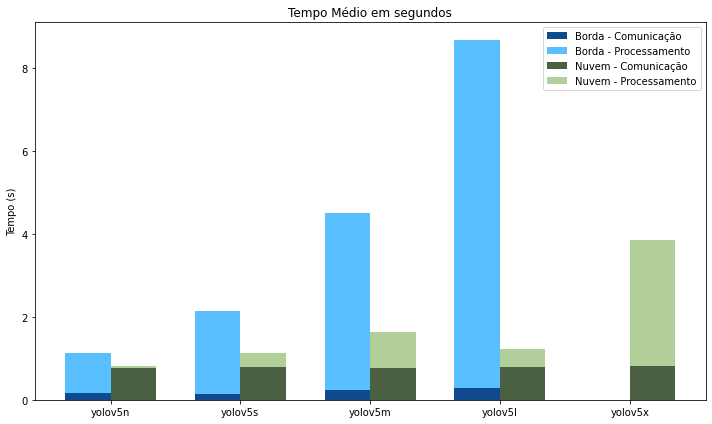

In [81]:
x = np.arange(len(labels))
width = 0.35 

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, time_com_edge, width, label='Borda - Comunicação', color="#104a8e")
rects1_1 = ax.bar(x - width/2, time_proc_edge, width, bottom=time_com_edge, label='Borda - Processamento', color="#59bfff")
rects2 = ax.bar(x + width/2, time_com_cloud, width, label='Nuvem - Comunicação', color="#4b6043")
rects2_2 = ax.bar(x + width/2, time_proc_cloud, width, bottom=time_com_cloud, label='Nuvem - Processamento', color="#b3cf99")

ax.set_ylabel('Tempo (s)')
ax.set_title('Tempo Médio em segundos')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()

plt.show()

In [85]:
np.array(time_com_cloud)/np.array(time_com_edge)

/tmp/ipykernel_1757247/3053821548.py:1: RuntimeWarning: divide by zero encountered in true_divide
  np.array(time_com_cloud)/np.array(time_com_edge)


array([4.76202344, 5.58318563, 3.40924254, 2.73278804,        inf])

In [83]:
time_com_cloud

[0.7613712118874537,
 0.7920884430164006,
 0.7765805978997378,
 0.792126084730553,
 0.807658721464104]

In [61]:
csv_save_cloud = "cloud/local_cloud_1fac85f4-8538-4205-860f-8745f7687861"
csv_predict_cloud = "cloud/cloud_49254778-dbd4-4bce-b39c-f3cd851b9337"
csv_save_edge = "edge/local-edge_06b95dfb-134d-4d12-a527-6bcb4b7219cb"
csv_predict_edge = "edge/edge_20009813-aa9d-4d67-8f16-75847212776d"

In [62]:
labels = ["borda", "nuvem"]

cloud_save = csv_metrics_save(csv_save_cloud, "cloud")
cloud_predict = csv_metrics_predict(csv_predict_cloud, "cloud")
edge_save = csv_metrics_save(csv_save_edge, "edge")
edge_predict = csv_metrics_predict(csv_predict_edge, "edge")

In [63]:
[edge_save[4]-edge_save[0], cloud_save[4]-cloud_save[0]]

[0.08770967741935531, 0.08739285714285683]

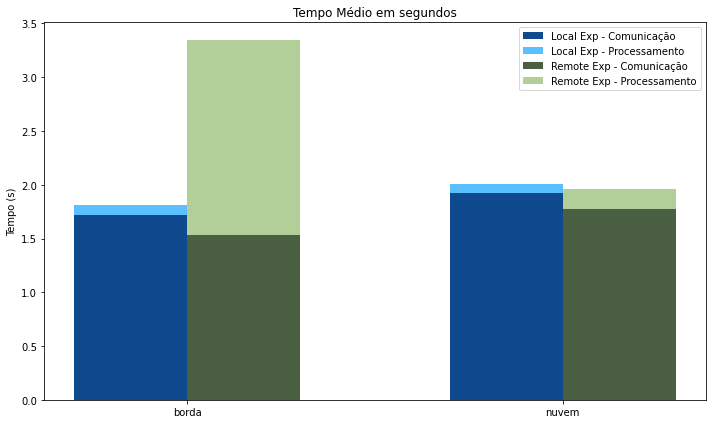

In [64]:
x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, [edge_save[0], cloud_save[0]], width, label='Local Exp - Comunicação', color="#104a8e")
rects1_1 = ax.bar(x - width/2, [edge_save[4]-edge_save[0], cloud_save[4]-cloud_save[0]], width, bottom=[edge_save[0], cloud_save[0]], label='Local Exp - Processamento', color="#59bfff")
rects2 = ax.bar(x + width/2, [edge_predict[0], cloud_predict[0]], width, label='Remote Exp - Comunicação', color="#4b6043")
rects2_2 = ax.bar(x + width/2, [edge_predict[2]-edge_predict[0], cloud_predict[2]-cloud_predict[0]], width, bottom=[edge_predict[0], cloud_predict[0]], label='Remote Exp - Processamento', color="#b3cf99")

ax.set_ylabel('Tempo (s)')
ax.set_title('Tempo Médio em segundos')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()

plt.show()